In [6]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Generate random measurements for each side of the polygon
# measurements = [1, 3, 5, 3, 8]

# # Calculate angles for each vertex of the pentagon
# angles = np.linspace(0, 2*np.pi, 5, endpoint=False)

# # Make the plot a closed polygon by repeating the first vertex at the end
# measurements = np.concatenate((measurements, [measurements[0]]))
# angles = np.concatenate((angles, [angles[0]]))

# # Create a radar (polar) plot
# plt.figure(figsize=(8, 8))
# plt.polar(angles, measurements, marker='o')

# # Set custom angle labels for each side of the polygon
# # plt.xticks(angles, ['Side 1', 'Side 2', 'Side 3', 'Side 4', 'Side 5'])

# # Set the title and show the plot
# plt.title("Radar Map of 5-Sided Polygon Measurements")
# plt.show()


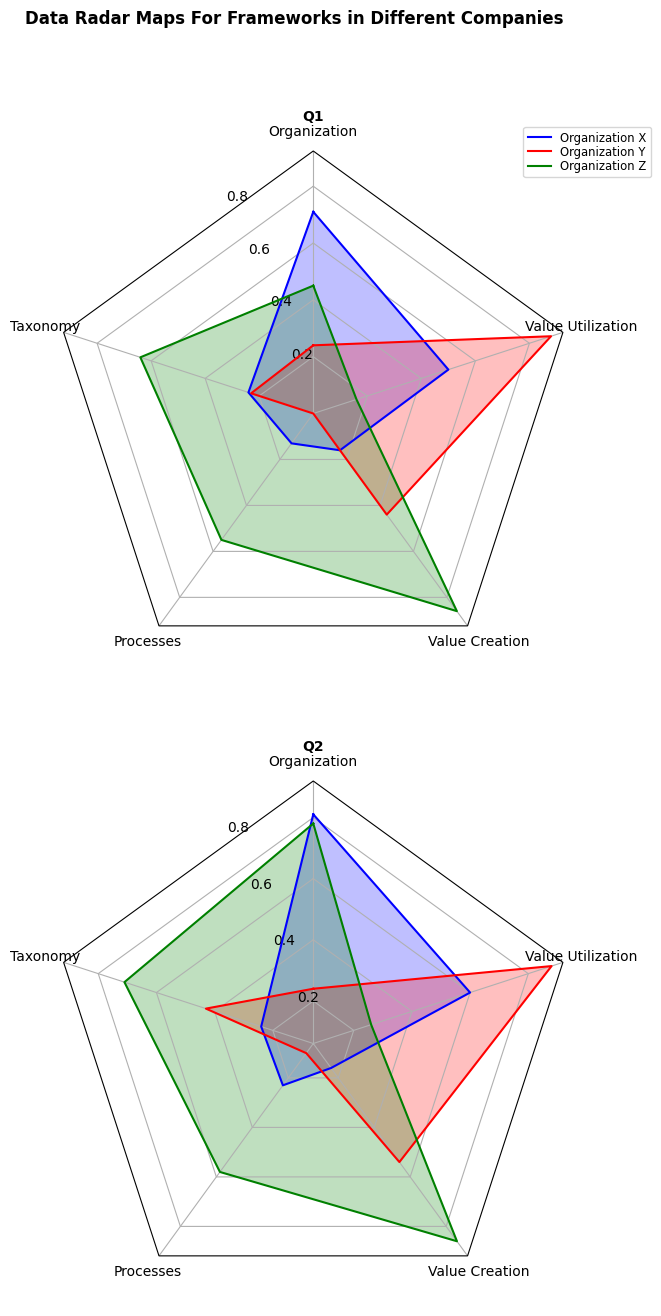

In [29]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolyzed Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Organization', 'Taxonomy', 'Processes', 'Value Creation', 'Value Utilization'],
        ('Q1', [
            [0.71, 0.24, 0.13, 0.16, 0.50],
            [0.24, 0.23, 0.00, 0.44, 0.88],
            [0.45, 0.64, 0.55, 0.86, 0.16]]),
        ('Q2', [
            [0.81, 0.24, 0.23, 0.16, 0.60],
            [0.24, 0.43, 0.10, 0.54, 0.88],
            [0.78, 0.71, 0.58, 0.86, 0.26]])
    ]
    return data


if __name__ == '__main__':
    N = 5
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(15, 15), nrows=2, ncols=1,
                            subplot_kw=dict(projection='radar'))
    # fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    # colors = ['#29004d', 'r', '#FFED00', 'm', 'y']
    colors = ['b', 'r', 'g', 'r', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('Organization X', 'Organization Y', 'Organization Z',)
    legend = axs[0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, 'Data Radar Maps For Frameworks in Different Companies',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()